* Extract cofactors (NADPH, NADH, ATP) balances
nadphs = ['nadph_c', 'nadph_m', 'nadph_x']
nadhs = ['nadh_c', 'nadh_m', 'nadh_x', 'nadh_r']
atps = ['atp_c', 'atp_m', 'atp_v', 'atp_n', 'atp_r'] 
* Include their all reactions (ID, name, equation) and  the cofactor balance in that reaction (flux) and % of total consumed/produced cofactor flux

In [1]:
import cobra
import pandas as pd
import os
from os.path import join
from cobra import Model, Reaction, Metabolite 
from cobra.sampling import sampling
import numpy as np
os.environ["R_HOME"] = f"{os.environ['CONDA_PREFIX']}\\Lib\\R"
import rpy2.robjects
from plotnine import *
import matplotlib.pyplot as plt
import copy

model_data=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\Rt_IFO0880.xml")



Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-21


In [2]:
# lab glucose_uptakes= [0.476, 1.114, 1.648, 2.305, 2.7, 3.1] # the fifth glc uptake value was calculated
growth_rates = [0.049, 0.100, 0.151, 0.203, 0.25, 0.301]


In [3]:
# Cofactor lists
nadphs = ['nadph_c', 'nadph_m', 'nadph_x']
nadhs = ['nadh_c', 'nadh_m', 'nadh_x', 'nadh_r']
atps = ['atp_c', 'atp_m', 'atp_v', 'atp_n', 'atp_r'] 


In [4]:
# Make a function for getting cofactor fluxes (all reactions where given metabolite is and their fluxes)

def cofactor_all_rxn_fluxes(cofactor_list, growth_rate):
    producing_fluxes = pd.DataFrame() 
    consuming_fluxes = pd.DataFrame()

    model = cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\Rt_IFO0880.xml")
    model.reactions.EX_glc__D_e.bounds = -9999, 9999
    model.reactions.BIOMASS_RT.bounds = growth_rate, growth_rate

    model.objective = "EX_glc__D_e" 
    solution = model.optimize('maximize') 
        
    for metabolite in cofactor_list:
        producing_fluxes = pd.concat([producing_fluxes, getattr(model.metabolites, metabolite).summary().producing_flux])
        consuming_fluxes = pd.concat([consuming_fluxes, getattr(model.metabolites, metabolite).summary().consuming_flux])
    
    for reaction in producing_fluxes.index:
        if reaction in consuming_fluxes.index and abs(round(producing_fluxes.loc[reaction, 'flux'], 3)) == abs(round(consuming_fluxes.loc[reaction, 'flux'], 3)):
            producing_fluxes = producing_fluxes.drop([reaction])
            consuming_fluxes = consuming_fluxes.drop([reaction])
            
    cofactor_fluxes = pd.concat([producing_fluxes, consuming_fluxes])

    cofactor_fluxes = cofactor_fluxes.sort_values(by='flux', ascending=False).drop(columns = ['percent']) # drop percent column, bc these percents are not for nadph sum (the percent is for specific compartment)
    cofactor_fluxes = cofactor_fluxes[(cofactor_fluxes['flux']) != 0.0] # for getting non-zero fluxes only

    cofactor_sum_producing_flux = sum(cofactor_fluxes[cofactor_fluxes['flux'] > 0]['flux']) # for getting the sum of producing fluxes
    cofactor_sum_consuming_flux = sum(cofactor_fluxes[cofactor_fluxes['flux'] < 0]['flux']) # for getting the sum of consumed fluxes
    print(f'SUM produced: {cofactor_sum_producing_flux}, SUM consumed: {cofactor_sum_consuming_flux}')

    if round(cofactor_sum_producing_flux, 3) == round(abs(cofactor_sum_consuming_flux), 3):
        cofactor_fluxes['percent'] = abs(cofactor_fluxes['flux']/cofactor_sum_producing_flux) # add percent column

    return cofactor_fluxes

In [5]:
# Making a pie chart
def cofactor_fluxes_pie_chart(cofactor_fluxes,  title, threshold): # threshold shows the percent of the flux for including in others sector on pie chart 
    # The three lines below are for grouping together reactions with low fluxes in producing
    producing_cofactor_fluxes_draw = cofactor_fluxes[(cofactor_fluxes['flux'] > 0).copy()]    
    producing_cofactor_fluxes_draw.loc[producing_cofactor_fluxes_draw['percent'] < threshold, 'reaction'] = 'Other producing'
    producing_cofactor_fluxes_draw = producing_cofactor_fluxes_draw.groupby('reaction')[['percent', 'flux']].sum()        
    
    # The three lines below are for grouping together reactions with low fluxes in consuming 
    consuming_cofactor_fluxes_draw = cofactor_fluxes[(cofactor_fluxes['flux'] < 0).copy()]
    consuming_cofactor_fluxes_draw.loc[consuming_cofactor_fluxes_draw['percent'] < threshold, 'reaction'] = 'Other consuming'
    consuming_cofactor_fluxes_draw = consuming_cofactor_fluxes_draw.groupby('reaction')[['percent', 'flux']].sum()
    
    # y_producing = producing_cofactor_fluxes_draw['percent']
    # labels_producing = producing_cofactor_fluxes_draw[['reaction', 'flux']] 
    
    # y_consuming = abs(consuming_cofactor_fluxes_draw['percent'])
    # labels_consuming = consuming_cofactor_fluxes_draw[['reaction', 'flux']]
    
    producing_and_consuming_fluxes = pd.concat([producing_cofactor_fluxes_draw, consuming_cofactor_fluxes_draw])
    
    # reaction_IDs = pd.concat([labels_producing, labels_consuming])
    
    model = cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\Rt_IFO0880.xml")
    model.objective = "EX_glc__D_e" 
    solution = model.optimize('maximize')   
    
    reaction_names_w_flux = []
    for reaction in producing_and_consuming_fluxes.index:
        if reaction != 'Other producing' and reaction != 'Other consuming':
            reaction_names_w_flux += [', '.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'%']), getattr(model.reactions, reaction).name, str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 3))])]
        elif reaction == 'Other producing':
            reaction_names_w_flux += [', '.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'%']), 'Other producing', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 3))])] 
        elif reaction == 'Other consuming':
            reaction_names_w_flux += [', '.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'%']), 'Other consuming', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 3))])] 
            
    pie_chart = plt.pie(producing_and_consuming_fluxes.loc[:, 'percent'], labels = reaction_names_w_flux)  #autopct='%1.1f%%' pd.concat([producing_cofactor_fluxes_draw, consuming_cofactor_fluxes_draw])[['flux', 'percent']]
    # plt.legend(producing_and_consuming_fluxes, reaction_names_w_flux, title = 'Reaction names', loc="center left",  bbox_to_anchor=(1, 0, 0.5, 1))
    
    plt.title(title)
    plt.show()  
    
    return pie_chart

In [6]:
# Get nadph fluxes at lowest biomass growth rate

nadph_fluxes_lowest_GR = cofactor_all_rxn_fluxes(nadphs, growth_rates[0])
nadph_fluxes_lowest_GR

# Get nadph fluxes at highest biomass growth rate
nadph_fluxes_highest_GR = cofactor_all_rxn_fluxes(nadphs, growth_rates[5])
nadph_fluxes_highest_GR


SUM produced: 0.8625472840166786, SUM consumed: -0.8625472840166786
SUM produced: 5.1419398738835245, SUM consumed: -5.1419398738835245


,flux,reaction,percent
ALCD2y,4.599957,ALCD2y,0.894596
ALDD2ym,0.310409,ALDD2ym,0.060368
PYDXOR,0.212579,PYDXOR,0.041342
PPND2,0.018994,PPND2,0.003694
3NPHBH2_m,-0.000223,3NPHBH2_m,0.000043
COQ7_m,-0.000223,COQ7_m,0.000043
DPR,-0.000232,DPR,0.000045
HEMEASm,-0.000416,HEMEASm,0.000081
KYN3OX,-0.000507,KYN3OX,0.000099
DHFR,-0.001934,DHFR,0.000376


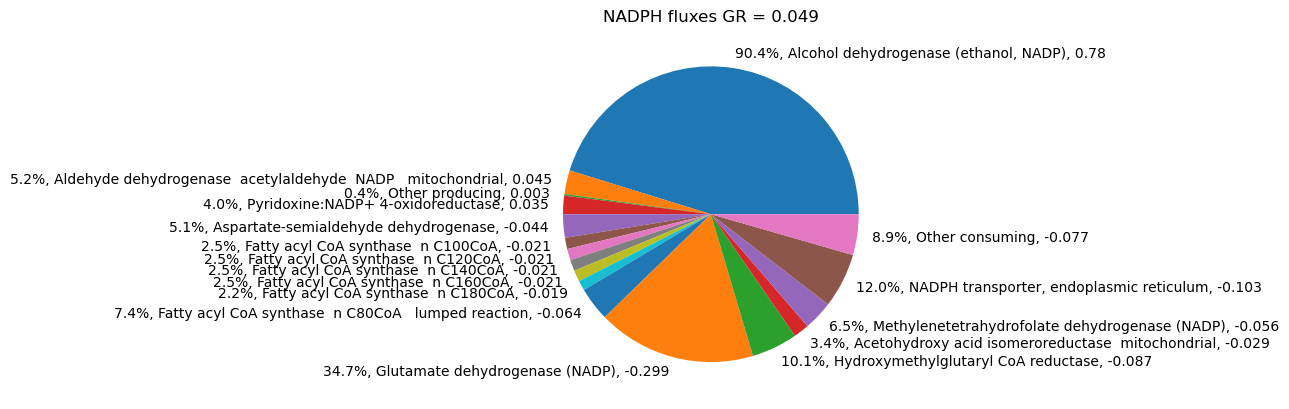

([<matplotlib.patches.Wedge at 0x1b88a149c10>,
 [Text(0.16468508441790794, 1.0876023275858997, '90.4%, Alcohol dehydrogenase (ethanol, NADP), 0.78'),
  Text(-1.07374319193786, 0.2389049136520559, '5.2%, Aldehyde dehydrogenase  acetylaldehyde  NADP   mitochondrial, 0.045'),
  Text(-1.0904778982665824, 0.14442282850054328, '0.4%, Other producing, 0.003'),
  Text(-1.0978162958228723, 0.06927756220990973, '4.0%, Pyridoxine:NADP+ 4-oxidoreductase, 0.035'),
  Text(-1.0964466654777432, -0.08834426842041422, '5.1%, Aspartate-semialdehyde dehydrogenase, -0.044'),
  Text(-1.0781983748260473, -0.21791802248201167, '2.5%, Fatty acyl CoA synthase  n C100CoA, -0.021'),
  Text(-1.0581639380402108, -0.3004814141194642, '2.5%, Fatty acyl CoA synthase  n C120CoA, -0.021'),
  Text(-1.0318171665691855, -0.3812523242855545, '2.5%, Fatty acyl CoA synthase  n C140CoA, -0.021'),
  Text(-0.9993152285354343, -0.45974892497663644, '2.5%, Fatty acyl CoA synthase  n C160CoA, -0.021'),
  Text(-0.9631372651755088, -

In [7]:
# Make a pie plot for napdh fluxes GR = 0.49
threshold = 0.02 # threshold for including reaction in 'others' in pie chart
title = 'NADPH fluxes GR = 0.049'
producing_nadph_fluxes_lowest_GR_pie_chart = cofactor_fluxes_pie_chart(nadph_fluxes_lowest_GR, title, threshold)
producing_nadph_fluxes_lowest_GR_pie_chart

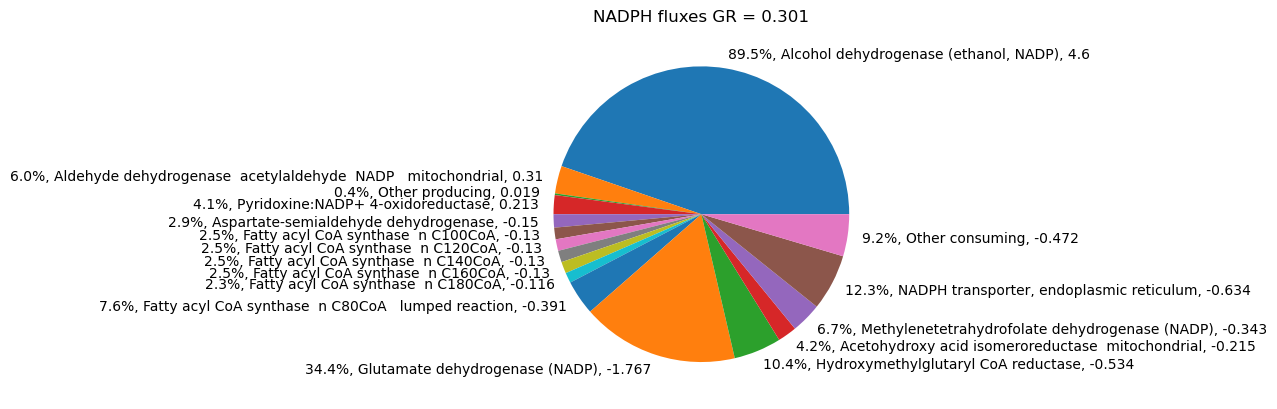

([<matplotlib.patches.Wedge at 0x1b88b37f3e0>,
 [Text(0.18129462437432803, 1.0849572614499483, '89.5%, Alcohol dehydrogenase (ethanol, NADP), 4.6'),
  Text(-1.0694289806376187, 0.2575299116071456, '6.0%, Aldehyde dehydrogenase  acetylaldehyde  NADP   mitochondrial, 0.31'),
  Text(-1.0898901120505324, 0.14879362773478608, '0.4%, Other producing, 0.019'),
  Text(-1.0976813416592113, 0.07138397700628889, '4.1%, Pyridoxine:NADP+ 4-oxidoreductase, 0.213'),
  Text(-1.0988498522505696, -0.050289185804717765, '2.9%, Aspartate-semialdehyde dehydrogenase, -0.15'),
  Text(-1.0905360628645464, -0.14398296979814806, '2.5%, Fatty acyl CoA synthase  n C100CoA, -0.13'),
  Text(-1.0756323546819397, -0.23024994584447978, '2.5%, Fatty acyl CoA synthase  n C120CoA, -0.13'),
  Text(-1.0539156163454462, -0.3150585241240085, '2.5%, Fatty acyl CoA synthase  n C140CoA, -0.13'),
  Text(-1.0255234011672978, -0.39787152908728934, '2.5%, Fatty acyl CoA synthase  n C160CoA, -0.13'),
  Text(-0.9927367012987919, -0.4

In [8]:
# Make a pie plot for nadph fluxes
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = 'NADPH fluxes GR = 0.301'
consuming_nadph_fluxes_highest_GR_pie_chart = cofactor_fluxes_pie_chart(nadph_fluxes_highest_GR, title, threshold)
consuming_nadph_fluxes_highest_GR_pie_chart

In [9]:
# Get nadh fluxes at lowest biomass growth rate

nadh_fluxes_lowest_GR = cofactor_all_rxn_fluxes(nadhs, growth_rates[0])
nadh_fluxes_lowest_GR

# Get nadh fluxes at highest biomass growth rate

nadh_fluxes_highest_GR = cofactor_all_rxn_fluxes(nadhs, growth_rates[5])
nadh_fluxes_highest_GR


SUM produced: 3.1409602972000163, SUM consumed: -3.1409602972000115
SUM produced: 17.450764595639942, SUM consumed: -17.450764595639942


,flux,reaction,percent
GAPD,4.678000,GAPD,2.680685e-01
MDHm,3.361774,MDHm,1.926434e-01
PDHm,3.300636,PDHm,1.891399e-01
ICDHxm,2.903379,ICDHxm,1.663755e-01
AKGDm,2.633144,AKGDm,1.508899e-01
IPMD,0.096382,IPMD,5.523065e-03
MMSAD3m,0.052208,MMSAD3m,2.991715e-03
3HPDm,0.052208,3HPDm,2.991715e-03
HICITDm,0.051873,HICITDm,2.972508e-03
SACCD2,0.051873,SACCD2,2.972508e-03


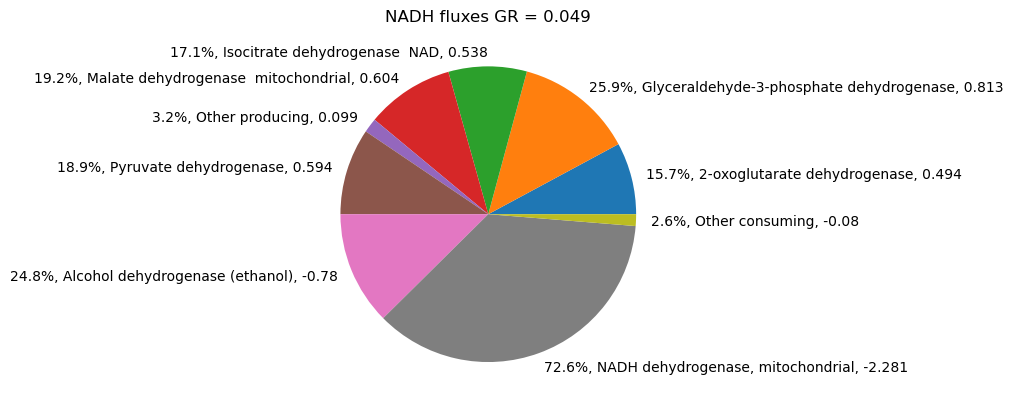

([<matplotlib.patches.Wedge at 0x1b88dbe9c10>,
 [Text(1.0666430362016632, 0.26883569949412905, '15.7%, 2-oxoglutarate dehydrogenase, 0.494'),
  Text(0.683658716027425, 0.8617486640545101, '25.9%, Glyceraldehyde-3-phosphate dehydrogenase, 0.813'),
  Text(-0.005024399249181407, 1.0999885251275057, '17.1%, Isocitrate dehydrogenase  NAD, 0.538'),
  Text(-0.5986801717941715, 0.9228120349781429, '19.2%, Malate dehydrogenase  mitochondrial, 0.604'),
  Text(-0.8798763709516005, 0.660164806575632, '3.2%, Other producing, 0.099'),
  Text(-1.0518218560016683, 0.3219794764223427, '18.9%, Pyruvate dehydrogenase, 0.594'),
  Text(-1.017361477584583, -0.41830087727246557, '24.8%, Alcohol dehydrogenase (ethanol), -0.78'),
  Text(0.3771051501135929, -1.033340072656531, '72.6%, NADH dehydrogenase, mitochondrial, -2.281'),
  Text(1.099112543375425, -0.04417710939847417, '2.6%, Other consuming, -0.08')])

In [10]:
# Make a pie plot for nadh fluxes
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = 'NADH fluxes GR = 0.049'
producing_nadh_fluxes_lowest_GR_pie_chart = cofactor_fluxes_pie_chart(nadh_fluxes_lowest_GR, title, threshold)
producing_nadh_fluxes_lowest_GR_pie_chart

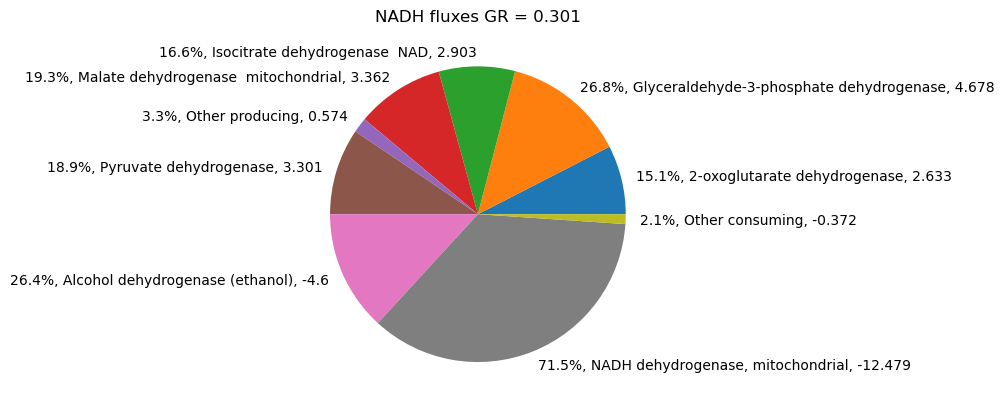

([<matplotlib.patches.Wedge at 0x1b88ea6b0e0>,
 [Text(1.0692469059809782, 0.25828483124276885, '15.1%, 2-oxoglutarate dehydrogenase, 2.633'),
  Text(0.6879714290417134, 0.858309567010821, '26.8%, Glyceraldehyde-3-phosphate dehydrogenase, 4.678'),
  Text(-0.007416496084222097, 1.0999749977094175, '16.6%, Isocitrate dehydrogenase  NAD, 2.903'),
  Text(-0.5942321066568326, 0.925682560826433, '19.3%, Malate dehydrogenase  mitochondrial, 3.362'),
  Text(-0.8784454549494035, 0.6620676571761648, '3.3%, Other producing, 0.574'),
  Text(-1.0518083195657624, 0.32202369306038253, '18.9%, Pyruvate dehydrogenase, 3.301'),
  Text(-1.0070461555011039, -0.4425585166850217, '26.4%, Alcohol dehydrogenase (ethanol), -4.6'),
  Text(0.4086007156091801, -1.0212959684653935, '71.5%, NADH dehydrogenase, mitochondrial, -12.479'),
  Text(1.0993835467068815, -0.03682142352216263, '2.1%, Other consuming, -0.372')])

In [11]:
# Make a pie plot for nadh fluxes
threshold = 0.02
title = 'NADH fluxes GR = 0.301'
consuming_nadh_fluxes_highest_GR_pie_chart = cofactor_fluxes_pie_chart(nadh_fluxes_highest_GR, title, threshold)
consuming_nadh_fluxes_highest_GR_pie_chart

In [12]:
# Get atp fluxes at lowest biomass growth rate

atps_fluxes_lowest_GR = cofactor_all_rxn_fluxes(atps, growth_rates[0])
atps_fluxes_lowest_GR

# Get nadph fluxes at highest biomass growth rate

atps_fluxes_highest_GR = cofactor_all_rxn_fluxes(atps, growth_rates[5])
atps_fluxes_highest_GR

SUM produced: 11.084292948083379, SUM consumed: -11.084292948083371
SUM produced: 61.20748128159978, SUM consumed: -61.207481281599804


,flux,reaction,percent
ATPS3m,47.714230,ATPS3m,0.779549
PGK,4.678000,PGK,0.076429
PYK,4.565323,PYK,0.074588
SUCOASm,2.631480,SUCOASm,0.042993
ACKr,1.616397,ACKr,0.026408
...,...,...,...
ACS,-1.646569,ACS,0.026901
PFK,-1.823046,PFK,0.029785
ADK1,-3.573342,ADK1,0.058381
HEX1,-4.008352,HEX1,0.065488


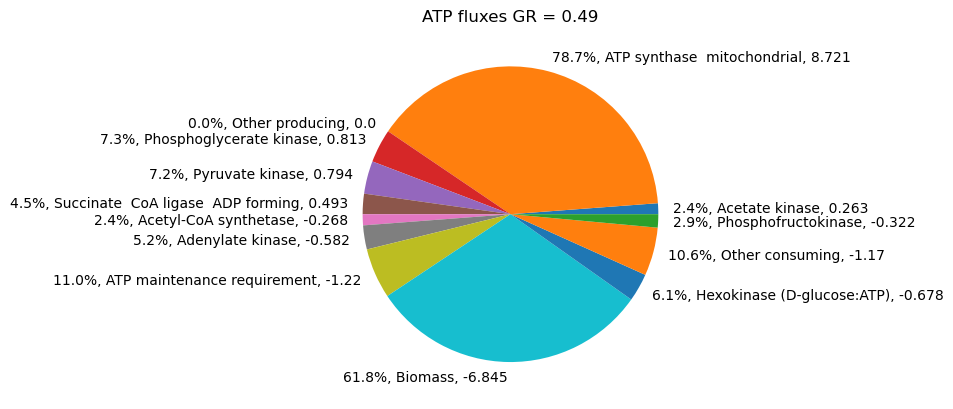

([<matplotlib.patches.Wedge at 0x1b891609e20>,
 [Text(1.0992352993912773, 0.041009225451954026, '2.4%, Acetate kinase, 0.263'),
  Text(0.2831826318062689, 1.06292407868261, '78.7%, ATP synthase  mitochondrial, 8.721'),
  Text(-0.9107946254232028, 0.6168088442136737, '0.0%, Other producing, 0.0'),
  Text(-0.9756524583798007, 0.5080376762184585, '7.3%, Phosphoglycerate kinase, 0.813'),
  Text(-1.06514894589691, 0.27469569172941505, '7.2%, Pyruvate kinase, 0.794'),
  Text(-1.0973118387376395, 0.076855244233696, '4.5%, Succinate  CoA ligase  ADP forming, 0.493'),
  Text(-1.0992065099759178, -0.041773776781167504, '2.4%, Acetyl-CoA synthetase, -0.268'),
  Text(-1.0862278177008304, -0.1735198203459521, '5.2%, Adenylate kinase, -0.582'),
  Text(-1.007188853941388, -0.44223366278047327, '11.0%, ATP maintenance requirement, -1.22'),
  Text(-0.01559501528600164, -1.0998894469437506, '61.8%, Biomass, -6.845'),
  Text(0.9552036794071416, -0.5455143727227166, '6.1%, Hexokinase (D-glucose:ATP), -0.6

In [13]:
# Make a pie plot for atp fluxes
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = 'ATP fluxes GR = 0.49'
producing_atps_fluxes_lowest_GR_pie_chart = cofactor_fluxes_pie_chart(atps_fluxes_lowest_GR, title,  threshold)
producing_atps_fluxes_lowest_GR_pie_chart

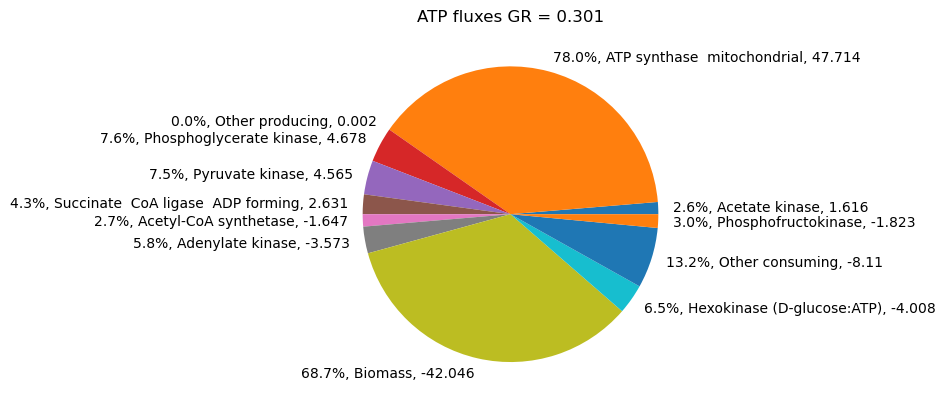

([<matplotlib.patches.Wedge at 0x1b8921cf320>,
 [Text(1.0990537029603702, 0.04561751866441727, '2.6%, Acetate kinase, 1.616'),
  Text(0.28631501122931213, 1.0620846079031365, '78.0%, ATP synthase  mitochondrial, 47.714'),
  Text(-0.9018964730263166, 0.629748165493708, '0.0%, Other producing, 0.002'),
  Text(-0.9708541377872156, 0.5171481829625263, '7.6%, Phosphoglycerate kinase, 4.678'),
  Text(-1.0651947856343678, 0.274517884039189, '7.5%, Pyruvate kinase, 4.565'),
  Text(-1.0974925916488254, 0.07422945019293069, '4.3%, Succinate  CoA ligase  ADP forming, 2.631'),
  Text(-1.0990180379526153, -0.04646883100298666, '2.7%, Acetyl-CoA synthetase, -1.647'),
  Text(-1.0829651160846918, -0.19283816360790768, '5.8%, Adenylate kinase, -3.573'),
  Text(-0.24415148683317978, -1.072562376497119, '68.7%, Biomass, -42.046'),
  Text(0.8999118849108089, -0.6325809034394535, '6.5%, Hexokinase (D-glucose:ATP), -4.008'),
  Text(1.0503165501292495, -0.3268564585939706, '13.2%, Other consuming, -8.11'),
 

In [14]:
# Make a pie plot for atp consuming fluxes
title = 'ATP fluxes GR = 0.301'
threshold = 0.02
consuming_atps_fluxes_highest_GR_pie_chart = cofactor_fluxes_pie_chart(atps_fluxes_highest_GR, title, threshold)
consuming_atps_fluxes_highest_GR_pie_chart

In [16]:
# # Get cofactor data to excel
# with pd.ExcelWriter('C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\Rt_IFO0880_results\\Glucose_maximization\\IFO0880_all_cofactor_fluxes.xlsx') as excel_writer:
#     nadph_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'NADPH fluxes, GR = {round(growth_rates[0], 2)}', index=False)
#     nadph_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'NADPH fluxes, GR = {round(growth_rates[5], 2)}', index=False)
#     nadh_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'NADH fluxes, GR = {round(growth_rates[0], 2)}', index=False)
#     nadh_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'NADH fluxes, GR = {round(growth_rates[5], 2)}', index=False)
#     atps_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'ATP fluxes, GR = {round(growth_rates[0], 2)}', index=False)
#     atps_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'ATP fluxes, GR = {round(growth_rates[5], 2)}', index=False)

    